<a href="https://colab.research.google.com/github/Panaxnotoginseng/Exercise-2-Xinyue/blob/main/Exercise_2_Code%20with%20comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

words = open('Chinese Names.txt', 'r', encoding='utf-8-sig').read().splitlines() # read all the names
chars = sorted(list(set(''.join(words)))) # build a list of characters appeared and mappings to/from integers
stoi = {s:i+1 for i,s in enumerate(chars)} # assign a number to each character
stoi['.'] = 0 # assign 0 to dot
itos = {i:s for s,i in stoi.items()} #create a dictionary that contains all the characters and corresponding number
print(itos)

{1: '一', 2: '丁', 3: '万', 4: '三', 5: '世', 6: '丙', 7: '业', 8: '东', 9: '严', 10: '中', 11: '丰', 12: '丹', 13: '丽', 14: '乃', 15: '义', 16: '乐', 17: '乔', 18: '九', 19: '书', 20: '予', 21: '二', 22: '于', 23: '云', 24: '亚', 25: '京', 26: '亮', 27: '人', 28: '仁', 29: '仇', 30: '介', 31: '从', 32: '仕', 33: '付', 34: '仙', 35: '代', 36: '仪', 37: '仲', 38: '任', 39: '伊', 40: '会', 41: '伟', 42: '传', 43: '何', 44: '余', 45: '作', 46: '佩', 47: '佳', 48: '侃', 49: '依', 50: '侠', 51: '侯', 52: '俊', 53: '保', 54: '俞', 55: '候', 56: '倩', 57: '倪', 58: '健', 59: '傅', 60: '储', 61: '元', 62: '兆', 63: '先', 64: '光', 65: '克', 66: '党', 67: '全', 68: '兰', 69: '关', 70: '兴', 71: '兵', 72: '其', 73: '典', 74: '冉', 75: '军', 76: '冠', 77: '冬', 78: '冯', 79: '冰', 80: '冲', 81: '冷', 82: '凝', 83: '凡', 84: '凤', 85: '凯', 86: '函', 87: '刑', 88: '刘', 89: '刚', 90: '初', 91: '利', 92: '前', 93: '剑', 94: '力', 95: '功', 96: '勇', 97: '勤', 98: '包', 99: '化', 100: '匡', 101: '升', 102: '华', 103: '单', 104: '南', 105: '博', 106: '卞', 107: '占', 108: '卢', 109: '卫', 110: '厚', 111: '友

In [2]:
# build the dataset

block_size = 4 # Chinese names normally have no more than three words. Take 4 characters to make prediction can prevent generating extremely long names

X, Y = [], [] #X is the input of the neural network, Y is the label of each example in X
for w in words[:20]: # take 20 names
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context) # the running context
    Y.append(ix) # the index of X
    context = context[1:] + [ix] # crop the context and append a new character in the sequence

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape) # from 20 names we get 77 examples (depending on name length). 4 input at each time.

torch.Size([77, 4]) torch.Size([77])


In [26]:
def build_dataset(words):
  X, Y = [], [] #X is the input of the neural network, Y is the label of each example in X
  for w in words:
    context = [0] * block_size #initialize with all dots
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context) # the running context
      Y.append(ix) # the index of X
      context = context[1:] + [ix] # crop the context and append a new character in the sequence

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# separate datasets
Xtr, Ytr = build_dataset(words[:n1]) # training set
Xdev, Ydev = build_dataset(words[n1:n2]) # validation set
Xte, Yte = build_dataset(words[n2:]) #test set

torch.Size([3070, 4]) torch.Size([3070])
torch.Size([384, 4]) torch.Size([384])
torch.Size([381, 4]) torch.Size([381])


In [4]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((687, 10), generator=g) # embed 687 different characters in 10 dimentional space
W1 = torch.randn((40, 200), generator=g) #set hidden layer with 40 inputs and 100 neurons
b1 = torch.randn(200, generator=g) # set bias for the 100 neurons in hidden layer
W2 = torch.randn((200, 687), generator=g) #set output layer with 100 inputs and 687 neurons
b2 = torch.randn(687, generator=g) # set bias for the 687 neurons in output layer

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True # make sure all parameters have gradient


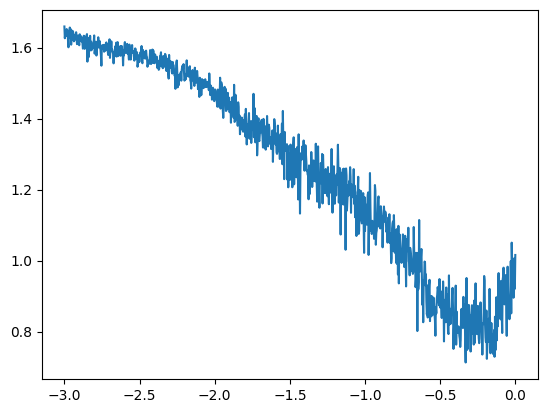

In [5]:
# find proper learning rate
import matplotlib.pyplot as plt # for making figures and find proper learning rate
%matplotlib inline

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []


for i in range(1000):

  # construct minibatches of 80 examples
  ix = torch.randint(0, Xtr.shape[0], (80,))

  # forward pass
  emb = C[Xtr[ix]] # (80, 4, 10)
  h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (80, 100)
  logits = h @ W2 + b2 # (80, 687) outcomes
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None # set gradient to 0 every time
  loss.backward()

  # update parameters
  lr = lrs[i]
  ##lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  #track status
  lri.append(lre[i])
  lossi.append(loss.log10().item())

plt.plot(lri,lossi) # exponent of the best learning rate is around -0.3, 10 to -0.3 is about 0.5

In [17]:
# training
for i in range(20000):

  # construct minibatches of 80 examples
  ix = torch.randint(0, Xtr.shape[0], (80,))

  # forward pass
  emb = C[Xtr[ix]] # (80, 4, 10)
  h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (80, 100)
  logits = h @ W2 + b2 # (80, 687) outcomes
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None # set gradient to 0 every time
  loss.backward()

  # update parameters
  lr = 0.5 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

2.536689281463623


In [18]:
# test on validation set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 40) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(5.8464, grad_fn=<NllLossBackward0>)


In [19]:
# test on test set
emb = C[Xte]
h = torch.tanh(emb.view(-1, 40) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(loss)

tensor(6.0521, grad_fn=<NllLossBackward0>)


In [27]:
# generate names
g = torch.Generator().manual_seed(21474697787) # for reproducibility

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all dots
    while True:
      emb = C[torch.tensor([context])] # (single example,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1) # normalized probability
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0: #generating a dot means the name ends
        break

    print(''.join(itos[i] for i in out))

钱英达.
杜念丹.
谢旺春.
荀晴.
高永乐.
李梓英.
阮伟奇.
羊剑.
姚花坚.
庞明兵.
王志忠.
吕恒美.
叶雪阳.
曹人凤.
谢法鑫.
徐玲旭.
荀瑞.
林继先.
陈世洋.
邵祖强.
